# Data integration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

from protvi.models import PROTVI
import protvi.plots as pl
import protvi.utils as utils
import protvi.metrics as metrics
import protvi.benchmark_models as bm

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


In [2]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Data loading

In [3]:
DATA_DIR = "../../data/processed"

In [4]:
adata_plexdia = sc.read(os.path.join(DATA_DIR, "leduc2022_plexDIA_proteins.h5ad"))
adata_pscope = sc.read(os.path.join(DATA_DIR,"leduc2022_pSCoPE_proteins_norm2.h5ad"))

In [5]:
adata_pscope.obs["study"] = "leduc2022_pSCoPE"
adata_pscope = adata_pscope[:,~adata_pscope.var["Leading.razor.protein"].str.contains("REV_")].copy()

In [6]:
adata_plexdia.obs["study"] = "leduc2022_plexDIA"
adata_plexdia.obs["Set"] = adata_plexdia.obs.Run.values
adata_plexdia.obs["Channel"] = adata_plexdia.obs.Label.values

Concat the two studies.

In [7]:
adata = adata_pscope.concatenate(adata_plexdia, join = "outer")
#adata = adata_pscope.copy()
adata.layers["raw"] = adata.X.copy()

Feature selection based on dropout and mean expression

In [8]:
detections = np.mean(~np.isnan(adata.layers["raw"]), axis=0)
ave_exp = np.nanmean(adata.layers["raw"], axis=0)

In [9]:
mask = np.where((detections < 0.1) & (ave_exp > 0.8))[0] # high abundance features are more likely to contribute to the representations
outlier = np.repeat(False, len(detections))
outlier[mask] = True

In [10]:
scF_df = pd.DataFrame({"x": ave_exp, "y": detections, "outlier": outlier} )

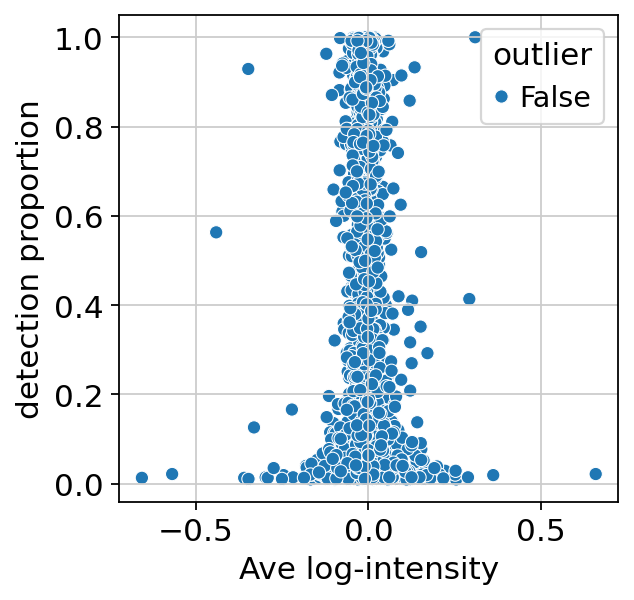

In [11]:
ax = sns.scatterplot(data = scF_df, x="x", y="y", hue= "outlier")
ax.set(xlabel="Ave log-intensity", ylabel="detection proportion")
plt.show()

In [12]:
# adata = adata[:, ~scF_df.outlier].copy() # this is potentially selecting features only in dia_plex study

##### General feature selection (based on detection only)

In [13]:
adata.obs["Set"] = adata.obs["Set"].astype("str")
adata.obs["Set"] = adata.obs["Set"].astype("category")


adata.obs.Channel = adata.obs.Channel.astype("str")
adata.obs.Channel = adata.obs.Channel.astype("category")

In [14]:
df = pd.DataFrame(~np.isnan(adata.layers["raw"]))
mask = np.where((df.groupby(adata.obs["Set"].values).mean() > 0.2).sum(0) >= 35)[0]

adata = adata[:,mask].copy()

In [15]:
adata.obs["File ID"] = adata.obs.Set.values

In [16]:
adata.X[np.isnan(adata.layers["raw"])] = 0

In [17]:
adata.obs["lcbatch"] = adata.obs["lcbatch"].astype("str")
adata.obs["lcbatch"] = adata.obs["lcbatch"].astype("category")

adata.obs["SampleType"] = adata.obs["SampleType"].astype("str")
adata.obs["SampleType"] = adata.obs["SampleType"].astype("category")

In [18]:
PROTVI.setup_anndata(adata, 
                     batch_key = "study",
                     categorical_covariate_keys = ["Channel", "Set"],
                     #prior_categorical_covariate_keys = ["SampleType"]
                    )


model = PROTVI(adata, log_variational=False, n_hidden=128, n_layers=1, decoder_type="selection") # decoder_type = "conjunction", max_loss_dropout = 0.1, 0.8

In [19]:
model.train(max_epochs=5000, plan_kwargs={"mechanism_weight": 0, 'kl_weight': 120}, check_val_every_n_epoch=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5000/5000: 100%|██████████| 5000/5000 [22:44<00:00,  4.28it/s, v_num=1, train_loss_step=263, train_loss_epoch=234]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 5000/5000: 100%|██████████| 5000/5000 [22:44<00:00,  3.66it/s, v_num=1, train_loss_step=263, train_loss_epoch=234]


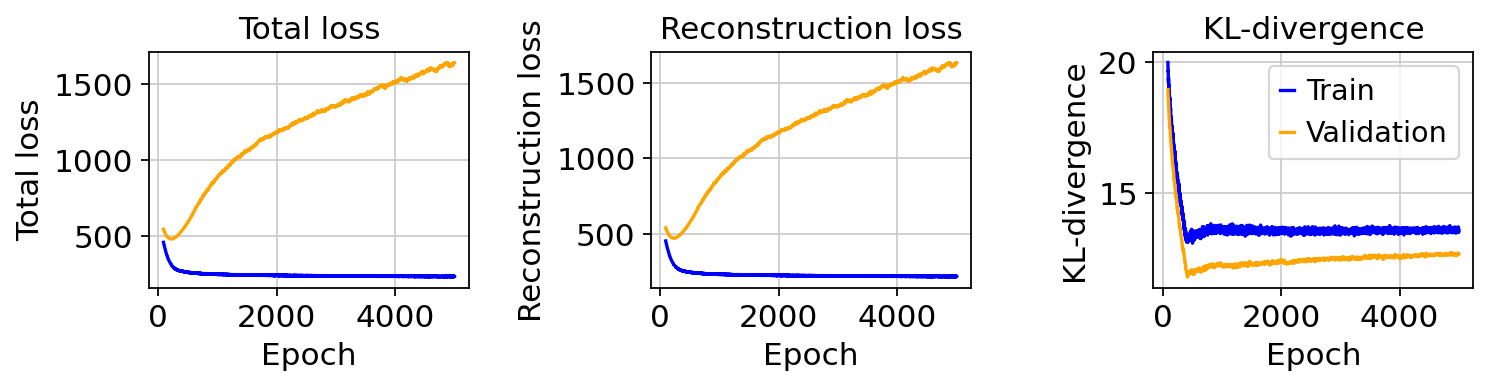

In [20]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

In [21]:
#model.save("leduc2022_pSCoPE_plexDIA")

In [22]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

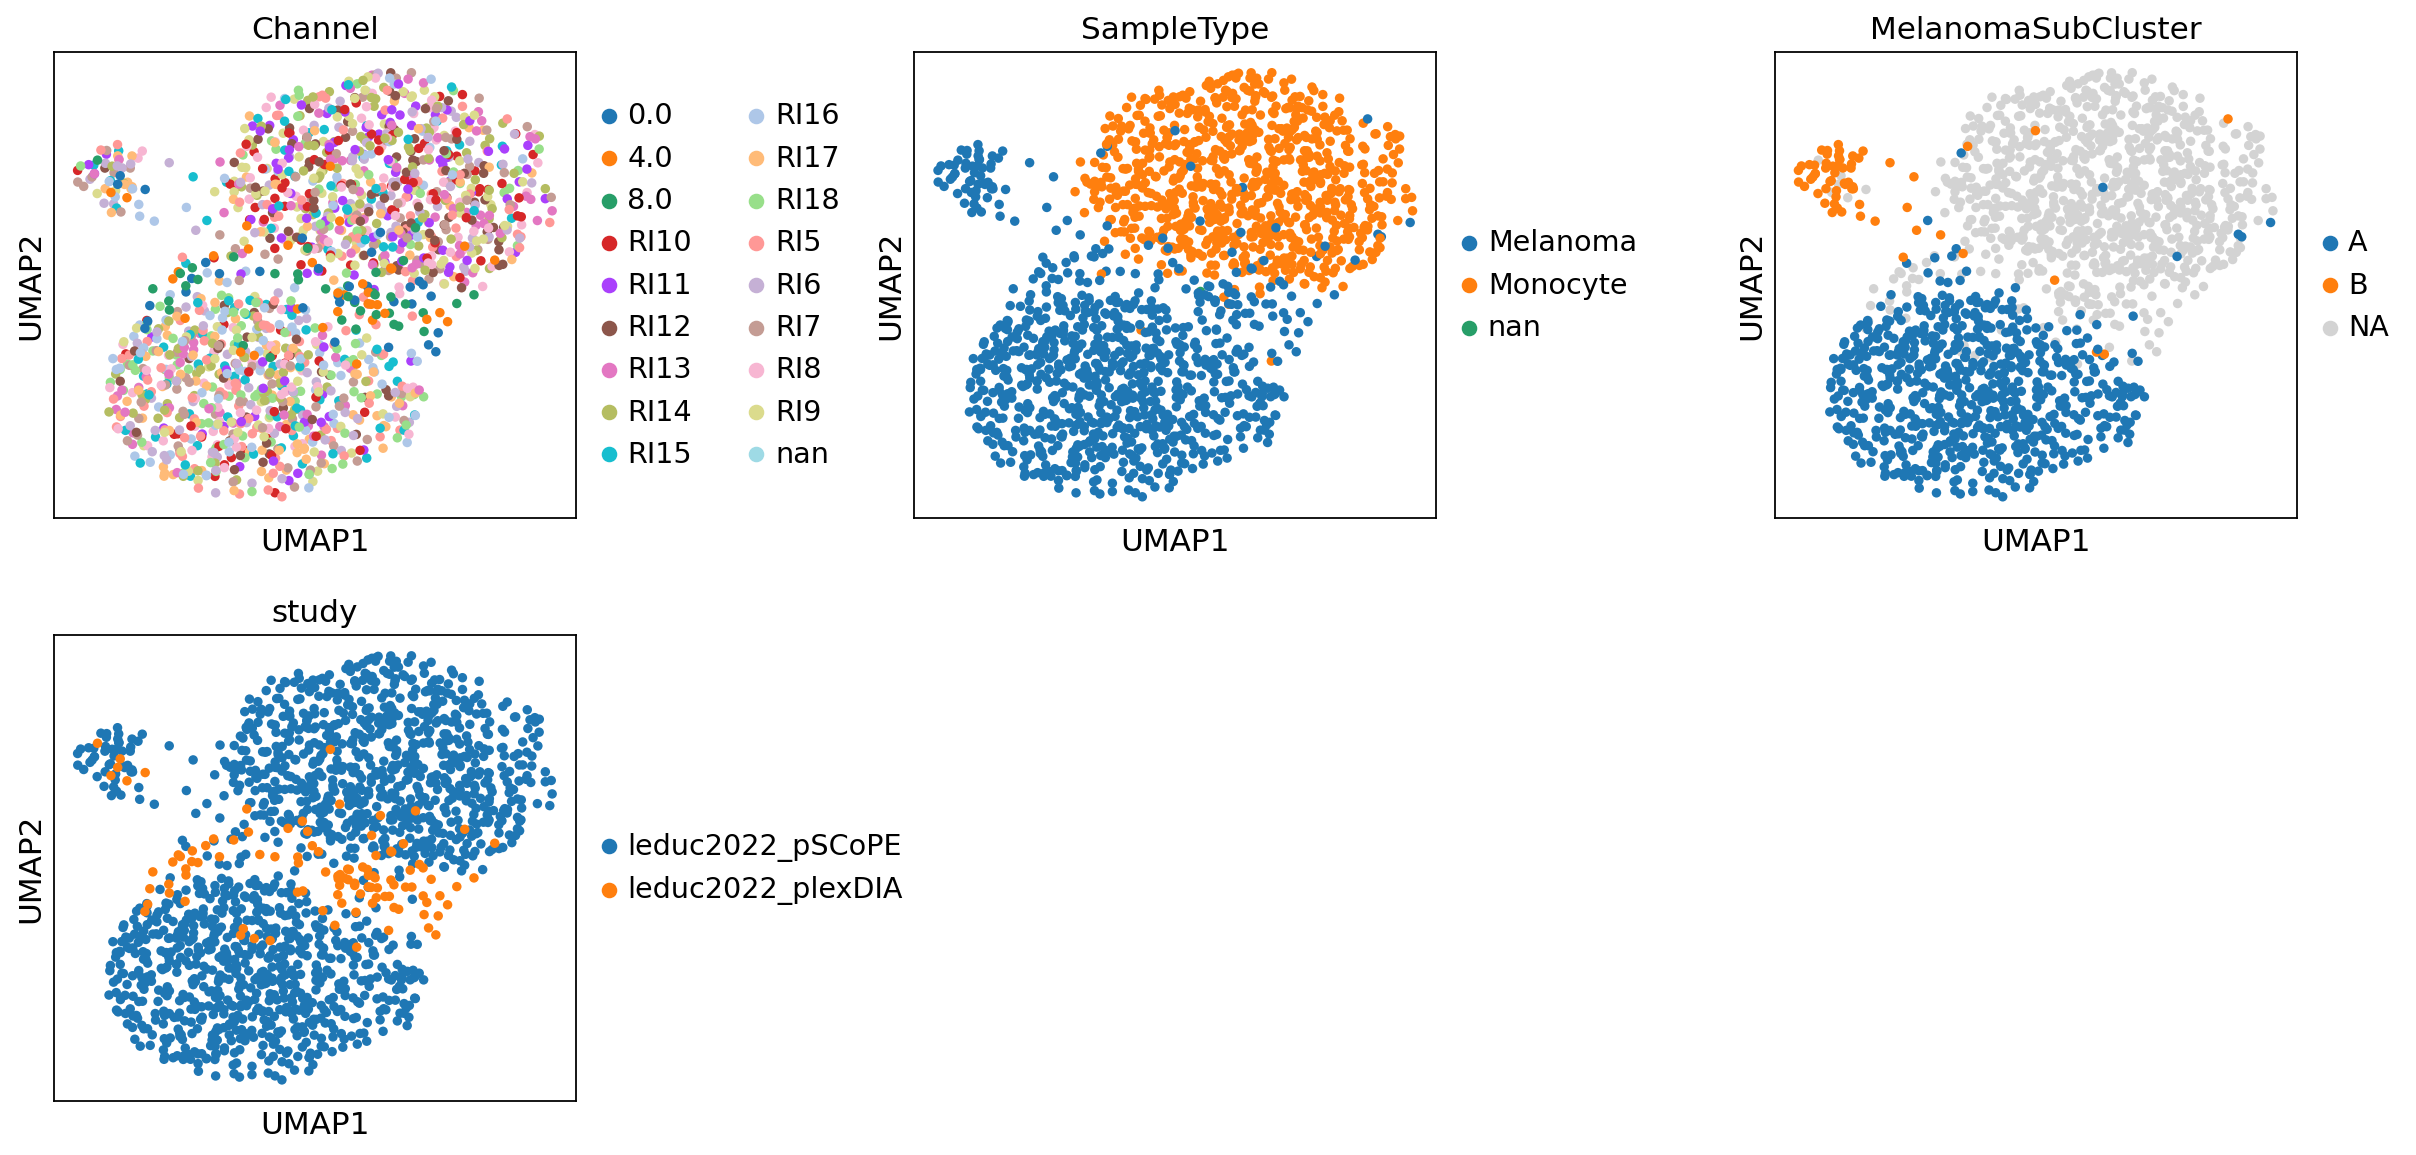

In [23]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Channel", "SampleType", "MelanomaSubCluster","study"], 
    vmin="p01", vmax="p99", ncols=3, wspace=0.5,
)

In [24]:
sc.pp.pca(adata)

In [25]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

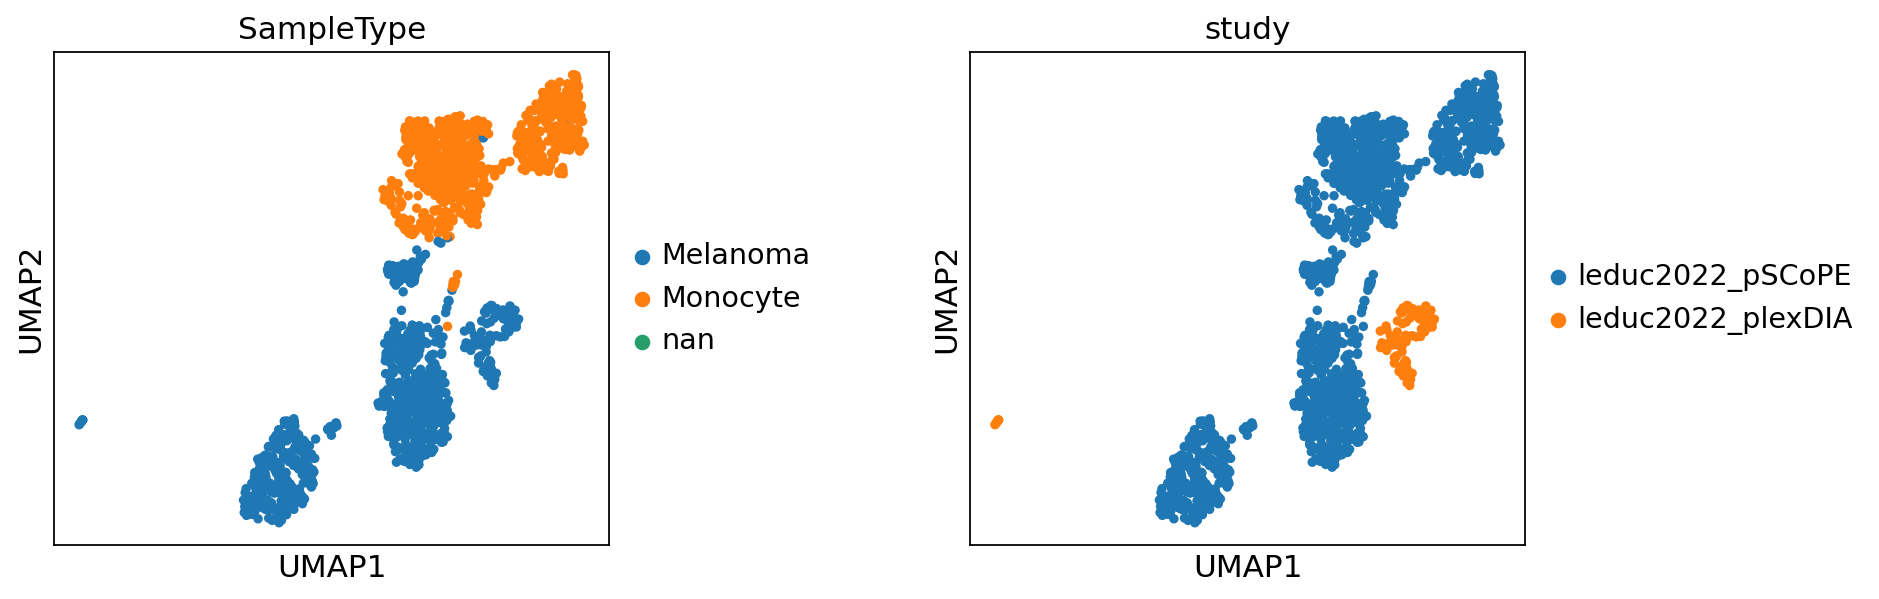

In [26]:
sc.pl.umap(
    adata, 
    color=["SampleType","study"], 
    vmin="p01", vmax="p99",ncols = 2, wspace = 0.5,
)

In [27]:
x_est, p_est = model.impute()

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

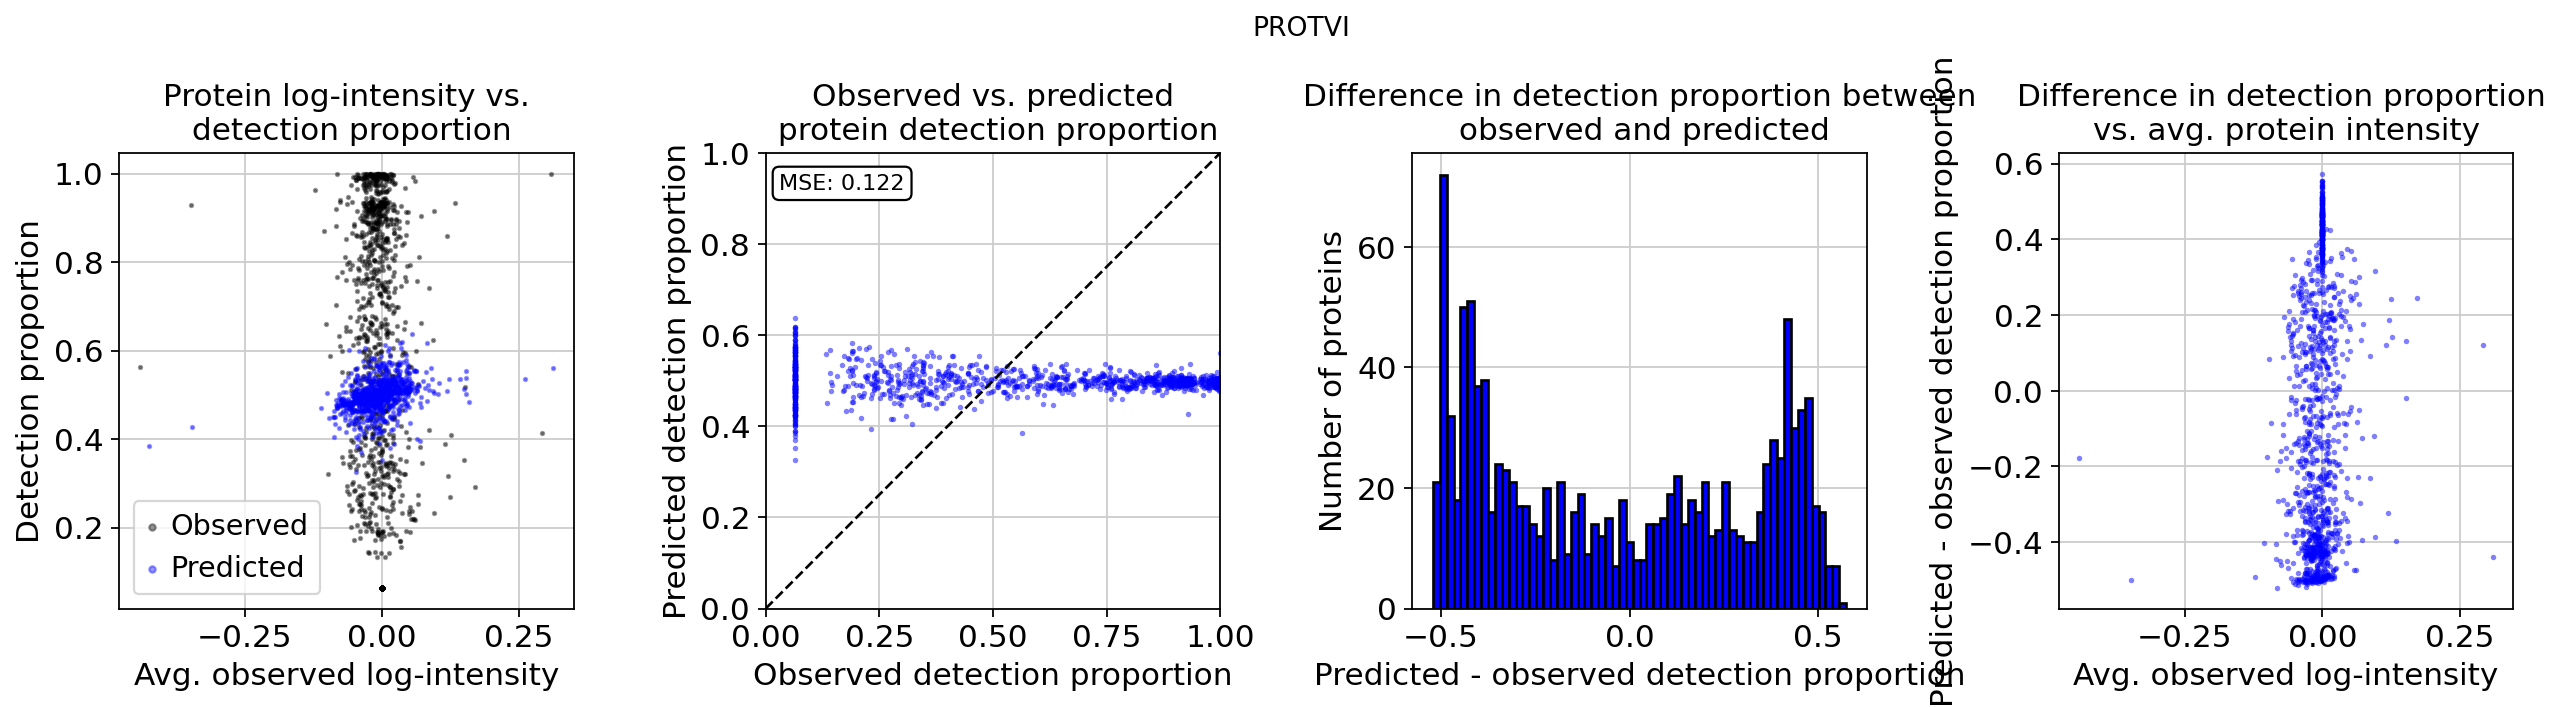

In [28]:
pl.plot_protein_detection_proportion_panel(x_data, p_est, x_est=x_est_obs)

## downshift normal + combat

In [29]:
adata.X = adata.layers["raw"].copy()

In [30]:
adata.X = bm.impute_knn(adata) #bm.impute_downshifted_normal_local(adata)

/home/rasmus/anaconda3/envs/scp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rasmus/anaconda3/envs/scp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rasmus/anaconda3/envs/scp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rasmus/anaconda3/envs/scp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [31]:
sc.pp.combat(adata, key="study") #, covariates=["Channel", "Set"])

In [32]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=False, svd_solver="arpack")

In [33]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

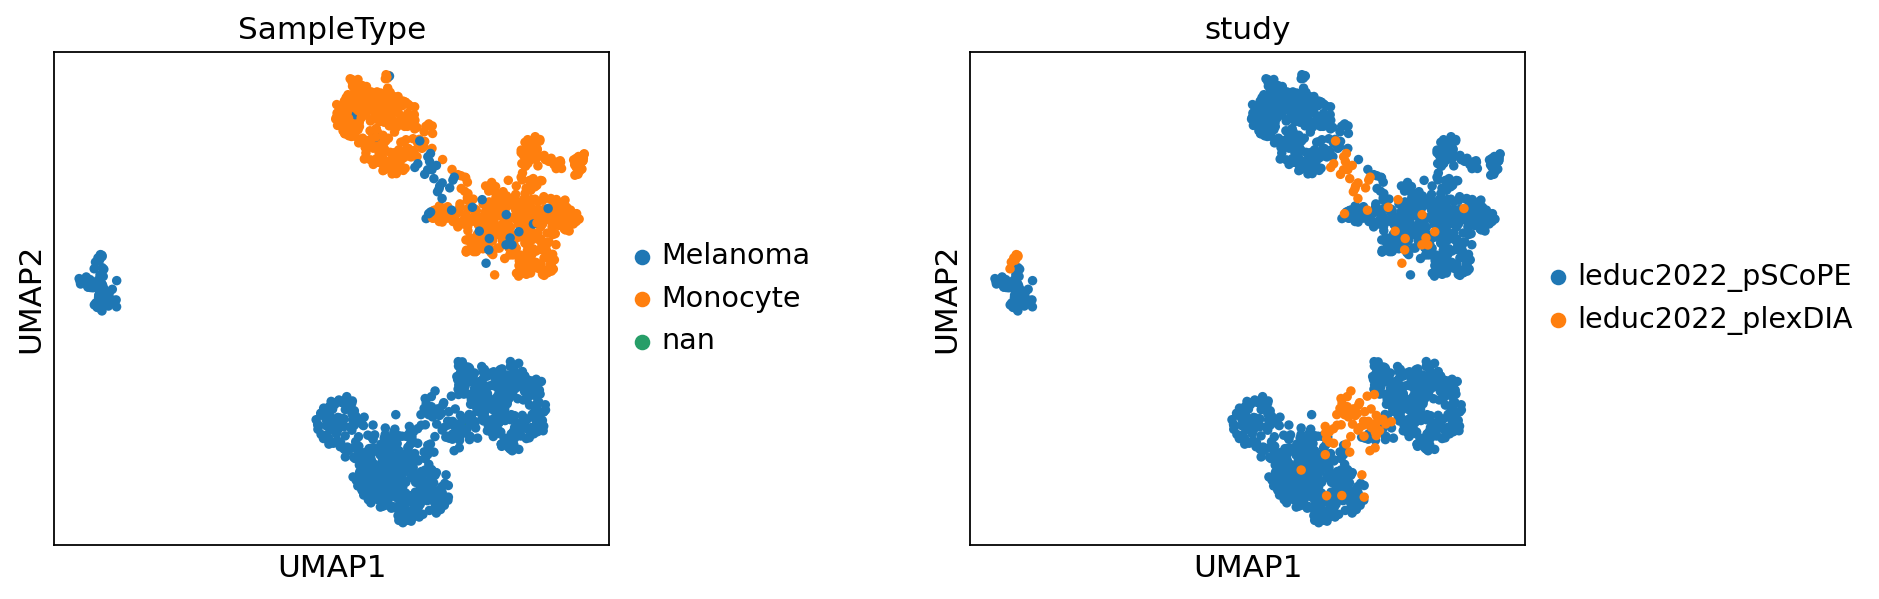

In [34]:
sc.pl.umap(
    adata, 
    color=["SampleType", "study"], 
    vmin="p01", vmax="p99", ncols=2, wspace=0.5,
)